# Simulator

In [1]:
import math
import simpy
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from shapely.geometry import Polygon, Point

In [2]:
class GeneralPatrolSimulation(object):
    """
    A class that implements a simple patrol scenario where the arrival rate of 
    events is homogeneous over the entire region. 
    """
    def __init__(self, env, region, polices, speed, eta, event_lam, niters=1000):
        self.region           = region
        self.polices          = polices
        self.speed            = speed
        self.event_lam        = event_lam
        self.event_prob       = event_lam/sum(event_lam)
        self.eta              = eta

        self.waiting_times    = []
        self.travel_times     = []
        self.response_times   = []
        self.service_times    = []
        self.event_locs       = []
        self.assigned_polices = []
        self.num_region       = len(region)
        self.num_police       = len(polices)
        self.Rho              = np.zeros((self.num_police, self.num_region))
        self.t_matrix         = np.zeros((self.num_police, self.num_region))
        self.n_matrix         = np.zeros((self.num_police, self.num_region))

        self.env = env
        self.env.process(self.simulate(polices, event_lam=sum(event_lam)))           # simulation
        self.start_time       = self.env.now 
        self.env.run(until=niters)
        self.end_time         = self.env.now 

    def event(self, police, event_loc, event_region_id):
        """
        Simulate an event that requests a police to settle the case. An event 
        will be waiting for an available police to arrive the scene, and take 
        some time (exponential random variable) to settle the case.
        """

        init_time = self.env.now

        with police['resource'].request() as req:                               # wait for police's availability
            yield req 
            disp_time = self.env.now

            distance           = np.linalg.norm(
                np.array(police['location']) - np.array(event_loc))             # calculating the distance between police and the event
            travel_time        = distance / self.speed                          # travel time
            self._update_travel_matrix(event_region_id, police, travel_time)    # update travel time matrix (only when execute)
            yield self.env.timeout(travel_time)                                 # wait until the police commute to the location of the event
            police['location'] = event_loc                                      # update police position
            arrv_time          = self.env.now
            
            service_time       = random.expovariate(police['service_rate'])     # calculating the service duration
            yield self.env.timeout(service_time)                                # wait until the police settle the case
            # yield self.env.timeout(travel_time)                                 # return to station
            done_time = self.env.now

            self.assigned_polices.append(police["id"])
            self.waiting_times.append(disp_time - init_time)
            self.response_times.append(arrv_time - init_time)
            self.service_times.append(service_time)
            self.travel_times.append(travel_time)
            self.event_locs.append(event_loc)
        self.mtt_matrix = self.t_matrix/self.n_matrix

    def individual_workloads(self): # only consider the service time (not including travel time)
        """
        Return individual workloads (rho_i)
        """
        rho = np.zeros(len(self.polices))
        for i in range(len(self.assigned_polices)):
            police_id      = self.assigned_polices[i]
            service_time   = self.service_times[i]
            rho[police_id] += service_time
            

        rho = rho / (self.end_time - self.start_time)
        return rho
    
    def _policy(self, event_loc, event_region_id, polices):
        """
        Return the assigned police given the location of the events and all 
        available polices. 
        """

        region_eta = self.eta[event_region_id]
        assert abs(sum(region_eta) - 1) < 1e-3
        
        police_id = np.arange(0, len(polices), 1)

        available_polices_id = np.array([cur_id for cur_id in police_id if polices[cur_id]['resource'].count == 0 and region_eta[cur_id] > 0])
        # available_polices_id = np.array([cur_id for cur_id in police_id if region_eta[cur_id] > 0])
        if len(available_polices_id) > 0:
            new_eta = region_eta[available_polices_id]/sum(region_eta[available_polices_id])
            assigned_police_id = np.random.choice(available_polices_id, p=new_eta)
        else:
            assigned_police_id = np.random.choice(police_id, p=region_eta)
        
        police = polices[assigned_police_id]
        return police

    def simulate(self, polices, event_lam):
        """
        Simulate the process given the available polices as well as the arrival 
        rate of the events and servce rates of the polices.
        """
        for i in itertools.count():
            yield self.env.timeout(random.expovariate(event_lam))               # generate a new event according to event_lam 
            region_id = np.arange(0, len(self.region), 1)
            event_region_id = np.random.choice(region_id, p=self.event_prob)
            event_region = self.region[event_region_id]
            
            event_loc = [ 
                random.uniform(
                    event_region[:, 0].min(), event_region[:, 0].max()),
                random.uniform(
                    event_region[:, 1].min(), event_region[:, 1].max()) ]         # generate the random location within the specified polygon for the event
            police = self._policy(event_loc, event_region_id, polices)            # choose the police to serve the call
            self.env.process(
                self.event(police, event_loc, event_region_id))                   # simulate the process of the service for this call
    
    def _update_travel_matrix(self, event_region_id, police, travel_time):
        """
        General case
        """
        self.n_matrix[police['id'], event_region_id] += 1
        self.t_matrix[police['id'], event_region_id] += travel_time
        self.Rho[police['id'], event_region_id] += 1

In [3]:
env = simpy.Environment()
lambda_list = np.array([1, 1, 1, 1])
mu = sum(lambda_list)/len(lambda_list)
print('mu:', mu)
lambda_list = 1.5*lambda_list

eta = np.array([[1/2, (1/3)*(1/4), 1/4, (2/3)*(1/4)],
                [1/2, (1/3)*(1/4), 1/4, (2/3)*(1/4)],
                [1/2, (1/3)*(1/4), 1/4, (2/3)*(1/4)],
                [1/2, (1/3)*(1/4), 1/4, (2/3)*(1/4)]])


speed = 1e5

xmin = 0
ymin = 0
xmax = 100
ymax = 100

length = 100/2
wide = 100/2

cols = list(np.arange(xmin, xmax + wide, wide))
rows = list(np.arange(ymin, ymax + length, length))

polygons = []
regions = []
polices = []
index = 0
for x in cols[:-1]:
    for y in rows[:-1]:
        regions.append([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)])
        polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))
        police = {'id': index, 'location': (x+wide/2, y+length/2), 'region': polygons[index], 
                  'resource': simpy.Resource(env, capacity=1), 'service_rate': mu}
        polices.append(police)
        index += 1
        
regions = np.array(regions)

sim = GeneralPatrolSimulation(env, region=regions, polices=polices, speed=speed, eta=eta, event_lam=lambda_list, niters=1000)

mu: 1.0


/var/folders/c9/ksbw4s8j1y93c3n_6cqpxh980000gn/T/ipykernel_25455/291010865.py:64: RuntimeWarning: invalid value encountered in divide
  self.mtt_matrix = self.t_matrix/self.n_matrix


In [4]:
sim_rho = sim.individual_workloads()
sim_rho

array([0.9991123 , 0.91117278, 0.99850015, 0.98118823])

In [5]:
sim_Rho = sim.Rho/sim.Rho.sum()
sim_Rho

array([[0.06945143, 0.05485657, 0.06114746, 0.06643181],
       [0.05485657, 0.06467036, 0.05988928, 0.06542526],
       [0.06014092, 0.05686965, 0.06618017, 0.06794162],
       [0.06039255, 0.06391545, 0.06618017, 0.06165073]])

In [6]:
sim.mtt_matrix

array([[0.00052061, 0.00052774, 0.00052053, 0.00050731],
       [0.00056202, 0.00050424, 0.00052208, 0.00050744],
       [0.00053397, 0.00052257, 0.00053273, 0.0005248 ],
       [0.00052021, 0.00052693, 0.00052428, 0.00050555]])

In [7]:
sim_Rho_alt = sim_Rho.sum(axis=1)

# Hyperlattice Model

In [8]:
from hyperlatticeq import General_HyperlatticeQ, allocation
import numpy as np

In [9]:
N = 4
I = 4

A = np.ones((N, N))
aloc = allocation(I, lambda_list, A, mu, K=10, inf=10)
aloc.workload_std(eta)
lat_rho = aloc.perf.rho
lat_rho

array([0.99088548, 0.85021532, 0.91406819, 0.88530681])

In [10]:
mrt, mrt_server, mrt_region = aloc.mean_travel_time(eta, sim.mtt_matrix)

In [11]:
def individual_Rho(I, N, Lam, dict_Rho):
    Rho = np.zeros((I, N))
    dict = list(dict_Rho.values())[0]
    for n in range(N):
        ratio = Lam[n]/sum(Lam)
        for i in range(I):
            if i in dict:
                Rho[i][n] = dict[i]*ratio
    return Rho

In [12]:
lat_Rho = individual_Rho(I, N, lambda_list, aloc.perf.Rho)
lat_Rho_alt = lat_Rho.sum(axis=1)
lat_Rho_alt

array([0.3617746 , 0.17447372, 0.25065821, 0.21309347])

# Larson's Hypercube Model

In [13]:
import arrow
import numpy as np

In [14]:
def generate_P(N, I):
    P = np.random.rand(N, I).argsort()
    for i in range(N):
        if i == I:
            break
        if P[i][i] == 0:
            continue
        else:
            P[i][np.where(P[i] == 0)] = P[i][i]
            P[i][i] = 0
    return P

def generate_T(N, I):
    T = np.random.rand(N, I)
    for i in range(N):
        if i == I:
            break
        if i == np.where(T[i] == min(T[i])):
            continue
        else:
            min_value = min(T[i])
            T[i][np.where(T[i] == min(T[i]))] = T[i][i]
            T[i][i] = min_value
    return T

In [15]:
# - model configuration
n_atoms = N
P       = generate_P(N, I)
T       = generate_T(N, I)

In [16]:
from hypercubeq import Two_State_Hypercube

two_hq = Two_State_Hypercube({'Lambda':sum(lambda_list), 'frac_j': lambda_list/sum(lambda_list), 'Mu':mu, 'K': N, 'N': I, 't_mat': T})
two_hq.Myopic_Policy(source = 't_mat')
two_hq.Solve_Hypercube()
cub_rho = np.array(two_hq.rho_hyper)
cub_rho

array([0.7786466 , 0.79538948, 0.79663638, 0.81193623])

In [17]:
two_hq.Get_MRT_Hypercube()
cub_Rho = two_hq.q_nj.transpose()
cub_Rho

array([[0.1043264 , 0.04190744, 0.05651545, 0.04190744],
       [0.06504776, 0.09643528, 0.0369132 , 0.05152122],
       [0.03659609, 0.04993082, 0.09584761, 0.06793473],
       [0.04402976, 0.06172646, 0.06072374, 0.08863661]])

In [18]:
cub_Rho_alt = cub_Rho.sum(axis=1)
cub_Rho_alt

array([0.24465672, 0.24991746, 0.25030924, 0.25511657])

# Numerical Validation

In [19]:
def Frob_norm(Rho, sim_Rho):
    return np.linalg.norm(Rho - sim_Rho)

def generate_T(N, I):
    T = np.random.rand(N, I)
    for i in range(N):
        if i == I:
            break
        if i == np.where(T[i] == min(T[i])):
            continue
        else:
            min_value = min(T[i])
            T[i][np.where(T[i] == min(T[i]))] = T[i][i]
            T[i][i] = min_value
    return T

def individual_Rho(I, N, Lam, dict_Rho):
    Rho = np.zeros((I, N))
    dict = list(dict_Rho.values())[0]
    for n in range(N):
        ratio = Lam[n]/sum(Lam)
        for i in range(I):
            if i in dict:
                Rho[i][n] = dict[i]*ratio
    return Rho

def simulation(N, I, mu, Lam, eta):
    env = simpy.Environment()
    
    xmin = 0
    ymin = 0
    xmax = 100
    ymax = 100
    
    length = ymax/3
    wide = xmax/3
    speed = 1e5
    
    cols = list(np.arange(xmin, xmax + wide, wide))
    rows = list(np.arange(ymin, ymax + length, length))
    
    polygons = []
    regions = []
    polices = []
    index = 0
    for x in cols[:-1]:
        for y in rows[:-1]:
            regions.append([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)])
            polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))
            police = {'id': index, 'location': (x+wide/2, y+length/2), 'region': polygons[index], 
                      'resource': simpy.Resource(env, capacity=1), 'service_rate': mu}
            polices.append(police)
            index += 1
            
    regions = np.array(regions)
    sim = GeneralPatrolSimulation(env, region=regions[:N], polices=polices[:I], speed=speed, eta=eta, event_lam=Lam, niters=1000)
    return sim.individual_workloads(), sim.Rho/sim.Rho.sum(), sim.mtt_matrix

def hyperlattice(N, I, mu, Lam, eta, T=None):
    if T is None:
        T = generate_T(N, I)
    A = np.ones((N, N))
    aloc = allocation(I, Lam, A, mu, K=10, inf=10)
    aloc.workload_std(eta)
    mrt, mrt_server, mrt_region = aloc.mean_travel_time(eta, T)
    return aloc.perf.rho, individual_Rho(I, N, Lam, aloc.perf.Rho), mrt, mrt_region

def hypercube(N, I, mu, Lam, eta, T=None):
    if T is None:
        T = generate_T(N, I)
    two_hq = Two_State_Hypercube({'Lambda':sum(Lam), 'frac_j': Lam/sum(Lam), 'Mu':mu, 'K': N, 'N': I, 't_mat': T})
    two_hq.Myopic_Policy(source = 't_mat')
    two_hq.Solve_Hypercube()
    rho = np.array(two_hq.rho_hyper)
    MRT, MRT_j = two_hq.Get_MRT_Hypercube()
    Rho = two_hq.q_nj.transpose()
    return rho, Rho, MRT, MRT_j

def hypercube_approx(N, I, mu, Lam, eta, T=None):
    if T is None:
        T = generate_T(N, I)
    two_hq = Two_State_Hypercube({'Lambda':sum(Lam), 'frac_j': Lam/sum(Lam), 'Mu':mu, 'K': N, 'N': I, 't_mat': T})
    two_hq.Myopic_Policy(source = 't_mat')
    two_hq.Larson_Approx()
    rho = np.array(two_hq.rho_approx)
    MRT, MRT_j = two_hq.Get_MRT_Approx()
    Rho = two_hq.q_nj.transpose()
    return rho, Rho, MRT, MRT_j

In [20]:
N = 4
I = 4

Lam = np.array([1, 1, 1, 1])
mu = sum(Lam)/I
lam = 1
print('lam:', lam)
print('mu:', mu)

eta = np.array([[1/2, (1/3)*(1/4), 1/4, (2/3)*(1/4)],
                [1/2, (1/3)*(1/4), 1/4, (2/3)*(1/4)],
                [1/2, (1/3)*(1/4), 1/4, (2/3)*(1/4)],
                [1/2, (1/3)*(1/4), 1/4, (2/3)*(1/4)]])

lam: 1
mu: 1.0


In [21]:
sim_rho, sim_Rho, sim_T = simulation(N, I, mu, lam*Lam, eta)
lat_rho, lat_Rho, lat_MRT, lat_MRT_j = hyperlattice(N, I, mu, lam*Lam, eta, sim_T)
cub_rho, cub_Rho, cub_MRT, cub_MRT_j = hypercube(N, I, mu, lam*Lam, eta, sim_T.transpose())
cub_approx_rho, cub_approx_Rho, cub_approx_MRT, cub_approx_MRT_j = hypercube_approx(N, I, mu, lam*Lam, eta, sim_T.transpose())

In [22]:
print('rho: hypercube = ', Frob_norm(cub_rho, sim_rho), ' hyperlattice = ', Frob_norm(lat_rho, sim_rho))
print('Rho: hypercube = ', Frob_norm(cub_Rho, sim_Rho), ' hyperlattice = ', Frob_norm(lat_Rho, sim_Rho))

rho: hypercube =  0.4365292489289931  hyperlattice =  0.12309887940142121
Rho: hypercube =  0.11721448697512016  hyperlattice =  0.024275979862089174


In [23]:
print(lat_MRT)
print(lat_MRT_j)
print(cub_MRT)
print(cub_MRT_j)

0.0004199740387686932
{(0, 1, 2, 3): 0.0004199740387686934}
0.00041508763691255044
[0.00038551 0.00034707 0.000483   0.00044478]


In [24]:
from tqdm.notebook import tqdm

def numerical_exp(lam_list):
    sim_rho_list = []
    sim_Rho_list = []
    lat_rho_list = []
    lat_Rho_list = []
    cub_rho_list = []
    cub_Rho_list = []
    sim_rho_path = []
    sim_Rho_path = []
    lat_rho_path = []
    lat_Rho_path = []
    cub_rho_path = []
    cub_Rho_path = []
    cub_rho_frob = []
    lat_rho_frob = []
    cub_Rho_frob = []
    lat_Rho_frob = []
    cub_Rho_alt_frob = []
    lat_Rho_alt_frob = []

    sim_MRT_list = []
    lat_MRT_list = []
    cub_MRT_list = []
    
    for lam in tqdm(lam_list):
        sim_rho, sim_Rho, sim_T = simulation(N, I, mu, lam*Lam, eta)
        lat_rho, lat_Rho, lat_MRT, lat_MRT_j = hyperlattice(N, I, mu, lam*Lam, eta, sim_T.transpose())
        cub_rho, cub_Rho, cub_MRT, cub_MRT_j = hypercube_approx(N, I, mu, lam*Lam, eta, sim_T.transpose())
        sim_rho_list.append(np.linalg.norm(sim_rho))
        sim_Rho_list.append(np.linalg.norm(sim_Rho))
        lat_rho_list.append(np.linalg.norm(lat_rho))
        lat_Rho_list.append(np.linalg.norm(lat_Rho))
        cub_rho_list.append(np.linalg.norm(cub_rho))
        cub_Rho_list.append(np.linalg.norm(cub_Rho))

        sim_MRT_list.append(np.mean(sim_T))
        lat_MRT_list.append(lat_MRT)
        cub_MRT_list.append(cub_MRT)

        sim_rho_path.append(sim_rho)
        sim_Rho_path.append(sim_Rho)
        lat_rho_path.append(lat_rho)
        lat_Rho_path.append(lat_Rho)
        cub_rho_path.append(cub_rho)
        cub_Rho_path.append(cub_Rho)
    
        cub_rho_frob.append(Frob_norm(cub_rho, sim_rho))
        lat_rho_frob.append(Frob_norm(lat_rho, sim_rho))
        cub_Rho_frob.append(Frob_norm(cub_Rho, sim_Rho))
        lat_Rho_frob.append(Frob_norm(lat_Rho, sim_Rho))
        cub_Rho_alt_frob.append(Frob_norm(cub_Rho.sum(axis=1), sim_Rho.sum(axis=1)))
        lat_Rho_alt_frob.append(Frob_norm(lat_Rho.sum(axis=1), sim_Rho.sum(axis=1)))
    norms = {
        'sim_rho': sim_rho_list,
        'sim_Rho': sim_Rho_list,
        'lat_rho': lat_rho_list,
        'lat_Rho': lat_Rho_list,
        'cub_rho': cub_rho_list,
        'cub_Rho': cub_Rho_list,
        'sim_MRT': sim_MRT_list,
        'lat_MRT': lat_MRT_list,
        'cub_MRT': cub_MRT_list
    }
    paths = {
        'sim_rho': sim_rho_path,
        'sim_Rho': sim_Rho_path,
        'lat_rho': lat_rho_path,
        'lat_Rho': lat_Rho_path,
        'cub_rho': cub_rho_path,
        'cub_Rho': cub_Rho_path,
    }
    return cub_rho_frob, lat_rho_frob, cub_Rho_frob, lat_Rho_frob, cub_Rho_alt_frob, lat_Rho_alt_frob, norms, paths


def numerical_sim(lam_list):
    sim_rho_path = []
    sim_Rho_path = []
    for lam in tqdm(lam_list):
        sim_rho, sim_Rho, sim_T = simulation(N, I, mu, lam*Lam, eta)
        sim_rho_path.append(sim_rho)
        sim_Rho_path.append(sim_Rho)
    paths = {
        'sim_rho': sim_rho_path,
        'sim_Rho': sim_Rho_path,
    }
    return paths

In [25]:
lam_list_sim = np.arange(0.01, 1.01, 0.01)
lam_list = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]

In [26]:
paths_sim = numerical_sim(lam_list_sim)

  0%|          | 0/100 [00:00<?, ?it/s]

In [27]:
cub_rho_frob, lat_rho_frob, cub_Rho_frob, lat_Rho_frob, cub_Rho_alt_frob, lat_Rho_alt_frob, norms, paths_lat = numerical_exp(lam_list)

  0%|          | 0/11 [00:00<?, ?it/s]

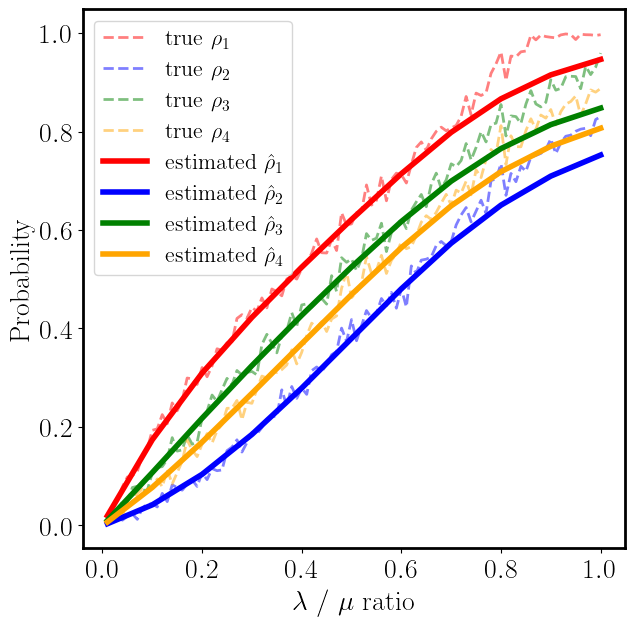

In [28]:
plt.rc('text', usetex=True)

font = {
    'family' : 'serif',
    'weight' : 'normal',
    'size'   : 20}
plt.rc('font', **font)
mpl.rcParams['axes.linewidth'] = 2

fig = plt.figure(figsize=(7, 7))

plt.plot(lam_list_sim, np.transpose(paths_sim['sim_rho'])[0], c='red', alpha=0.5, linewidth=2, ls='--', label=r"true $\rho_{1}$")
plt.plot(lam_list_sim, np.transpose(paths_sim['sim_rho'])[1], c='blue', alpha=0.5,  linewidth=2, ls='--', label=r"true $\rho_{2}$")
plt.plot(lam_list_sim, np.transpose(paths_sim['sim_rho'])[2], c='green', alpha=0.5,  linewidth=2, ls='--', label=r"true $\rho_{3}$")
plt.plot(lam_list_sim, np.transpose(paths_sim['sim_rho'])[3], c='orange', alpha=0.5,  linewidth=2, ls='--', label=r"true $\rho_{4}$")
plt.plot(lam_list, np.transpose(paths_lat['lat_rho'])[0], c='red',  linewidth=4, label=r"estimated $\hat{\rho}_{1}$")
plt.plot(lam_list, np.transpose(paths_lat['lat_rho'])[1], c='blue',  linewidth=4, label=r"estimated $\hat{\rho}_{2}$")
plt.plot(lam_list, np.transpose(paths_lat['lat_rho'])[2], c='green',  linewidth=4, label=r"estimated $\hat{\rho}_{3}$")
plt.plot(lam_list, np.transpose(paths_lat['lat_rho'])[3], c='orange',  linewidth=4, label=r"estimated $\hat{\rho}_{4}$")
plt.xlabel(r'$\lambda \ / \ \mu$ ratio')
plt.ylabel('Probability')
plt.legend(fontsize = 16)

# plt.savefig('plot/synthetic_rho_lat.png', dpi=300)

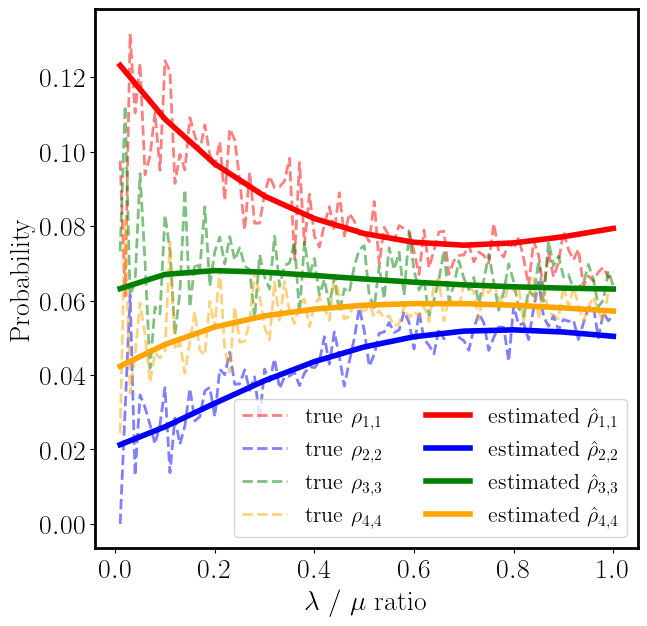

In [29]:
plt.rc('text', usetex=True)

font = {
    'family' : 'serif',
    'weight' : 'normal',
    'size'   : 20}
plt.rc('font', **font)
mpl.rcParams['axes.linewidth'] = 2

fig = plt.figure(figsize=(7, 7))

plt.plot(lam_list_sim, np.transpose(paths_sim['sim_Rho'])[0][0], c='red', alpha=0.5, ls='--', linewidth=2, label=r"true $\rho_{1,1}$")
plt.plot(lam_list_sim, np.transpose(paths_sim['sim_Rho'])[1][1], c='blue', alpha=0.5, ls='--', linewidth=2, label=r"true $\rho_{2,2}$")
plt.plot(lam_list_sim, np.transpose(paths_sim['sim_Rho'])[2][2], c='green', alpha=0.5, ls='--', linewidth=2, label=r"true $\rho_{3,3}$")
plt.plot(lam_list_sim, np.transpose(paths_sim['sim_Rho'])[3][3], c='orange', alpha=0.5, ls='--', linewidth=2, label=r"true $\rho_{4,4}$")
plt.plot(lam_list, np.transpose(paths_lat['lat_Rho'])[0][0], c='red', linewidth=4, label=r"estimated $\hat{\rho}_{1,1}$")
plt.plot(lam_list, np.transpose(paths_lat['lat_Rho'])[1][1], c='blue', linewidth=4, label=r"estimated $\hat{\rho}_{2,2}$")
plt.plot(lam_list, np.transpose(paths_lat['lat_Rho'])[2][2], c='green', linewidth=4, label=r"estimated $\hat{\rho}_{3,3}$")
plt.plot(lam_list, np.transpose(paths_lat['lat_Rho'])[3][3], c='orange', linewidth=4, label=r"estimated $\hat{\rho}_{4,4}$")
plt.xlabel(r'$\lambda \ / \ \mu$ ratio')
plt.ylabel('Probability')
plt.legend(fontsize = 16, ncol=2)

# plt.savefig('plot/synthetic_big_rho_cub.png', dpi=300)

# Plots

In [30]:
cub_rho_frob_paths = []
lat_rho_frob_paths = []
cub_Rho_frob_paths = []
lat_Rho_frob_paths = []
cub_Rho_alt_frob_paths = []
lat_Rho_alt_frob_paths = []

cub_rho_paths = []
cub_Rho_paths = []
lat_rho_paths = []
lat_Rho_paths = []
sim_rho_paths = []
sim_Rho_paths = []

cub_MRT_path = []
lat_MRT_path = []
sim_MRT_path = []

for i in range(10):
    cub_rho_frob, lat_rho_frob, cub_Rho_frob, lat_Rho_frob,  cub_Rho_alt_frob, lat_Rho_alt_frob, norms, _ = numerical_exp(lam_list)
    cub_rho_frob_paths.append(cub_rho_frob)
    lat_rho_frob_paths.append(lat_rho_frob)
    cub_Rho_frob_paths.append(cub_Rho_frob)
    lat_Rho_frob_paths.append(lat_Rho_frob)
    cub_Rho_alt_frob_paths.append(cub_Rho_alt_frob)
    lat_Rho_alt_frob_paths.append(lat_Rho_alt_frob)
    cub_rho_paths.append(norms['cub_rho'])
    cub_Rho_paths.append(norms['cub_Rho'])
    lat_rho_paths.append(norms['lat_rho'])
    lat_Rho_paths.append(norms['lat_Rho'])
    sim_rho_paths.append(norms['sim_rho'])
    sim_Rho_paths.append(norms['sim_Rho'])
    
    cub_MRT_path.append(norms['cub_MRT'])
    lat_MRT_path.append(norms['lat_MRT'])
    sim_MRT_path.append(norms['sim_MRT'])

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

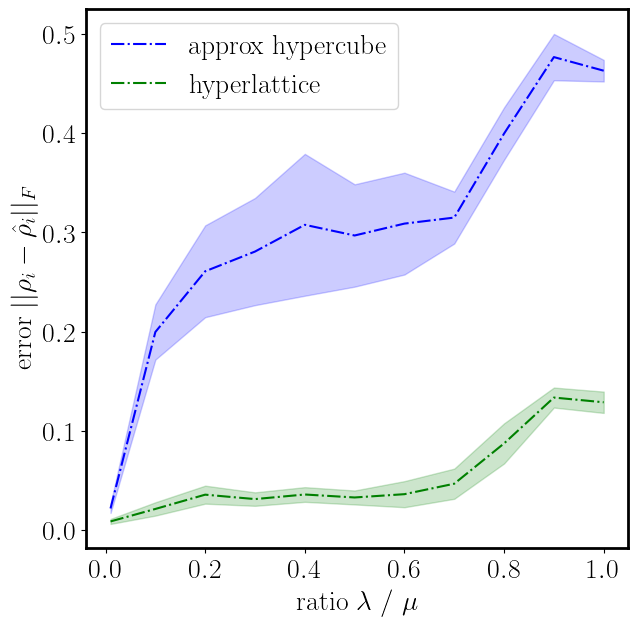

In [31]:
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rc('text', usetex=True)

font = {
    'family' : 'serif',
    'weight' : 'normal',
    'size'   : 20}
plt.rc('font', **font)
mpl.rcParams['axes.linewidth'] = 2

cub_rho_frob_paths_T = np.transpose(np.array(cub_rho_frob_paths))
avg_cub_rho_frob_T = np.mean(cub_rho_frob_paths_T, axis=1)

lat_rho_frob_paths_T = np.transpose(np.array(lat_rho_frob_paths))
avg_lat_rho_frob_T = np.mean(lat_rho_frob_paths_T, axis=1)


fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot()

ax.plot(lam_list, avg_cub_rho_frob_T, ls='-.', color = 'blue', label = 'approx hypercube')
ax.plot(lam_list, avg_lat_rho_frob_T, ls='-.', color = 'green', label = 'hyperlattice')
# ax.plot(lam_list, avg_cub_rho_frob_T - avg_lat_rho_frob_T, ls='--', color = 'red', label = 'mean gap')

# plt.grid(axis='x',linestyle='--')
plt.xlabel(r'ratio $\lambda \ / \ \mu$')
# plt.ylabel(r'Frobenius norm ($\rho_i$)')
plt.ylabel(r'error $||\rho_{i} - \hat{\rho}_{i}||_{F}$')
plt.legend()

cub_ci = 1.96 * np.std(cub_rho_frob_paths_T, axis=1)/np.sqrt(10)
lat_ci = 1.96 * np.std(lat_rho_frob_paths_T, axis=1)/np.sqrt(10)

plt.fill_between(lam_list, (avg_cub_rho_frob_T - cub_ci), (avg_cub_rho_frob_T + cub_ci), color='blue', alpha=.2)
plt.fill_between(lam_list, (avg_lat_rho_frob_T - lat_ci), (avg_lat_rho_frob_T + lat_ci), color='green', alpha=.2)

# plt.savefig('plot/small_rho_ci_approx.png', dpi=300)

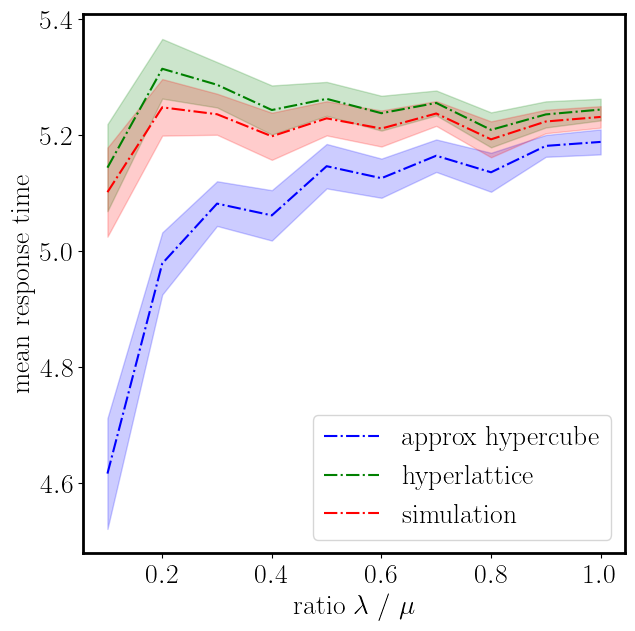

In [32]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

plt.rc('text', usetex=True)

font = {
    'family' : 'serif',
    'weight' : 'normal',
    'size'   : 20}
plt.rc('font', **font)
mpl.rcParams['axes.linewidth'] = 2

rescale = 10000

cub_MRT_path_T = np.transpose(np.array(cub_MRT_path))
avg_cub_MRT_path_T = np.mean(cub_MRT_path_T, axis=1) * rescale + 1/mu

lat_MRT_path_T = np.transpose(np.array(lat_MRT_path))
avg_lat_MRT_path_T = np.mean(lat_MRT_path_T, axis=1) * rescale + 1/mu

sim_MRT_path_T = np.transpose(np.array(sim_MRT_path))
avg_sim_MRT_path_T = np.mean(sim_MRT_path_T, axis=1) * rescale + 1/mu

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot()

ax.plot(lam_list, avg_cub_MRT_path_T, ls='-.', color = 'blue', label = 'approx hypercube')
ax.plot(lam_list, avg_lat_MRT_path_T, ls='-.', color = 'green', label = 'hyperlattice')
ax.plot(lam_list, avg_sim_MRT_path_T, ls='-.', color = 'red', label = 'simulation')

plt.xlabel(r'ratio $\lambda \ / \ \mu$')
plt.ylabel(r'mean response time')
plt.legend()

cub_ci = 1.96 * np.std(cub_MRT_path_T, axis=1) / np.sqrt(10) * rescale
lat_ci = 1.96 * np.std(lat_MRT_path_T, axis=1) / np.sqrt(10) * rescale
sim_ci = 1.96 * np.std(sim_MRT_path_T, axis=1) / np.sqrt(10) * rescale

plt.fill_between(lam_list, (avg_cub_MRT_path_T - cub_ci), (avg_cub_MRT_path_T + cub_ci), color='blue', alpha=.2)
plt.fill_between(lam_list, (avg_lat_MRT_path_T - lat_ci), (avg_lat_MRT_path_T + lat_ci), color='green', alpha=.2)
plt.fill_between(lam_list, (avg_sim_MRT_path_T - sim_ci), (avg_sim_MRT_path_T + sim_ci), color='red', alpha=.2)

# plt.savefig('plot/MRT_ci_approx.png', dpi=300)
plt.show()

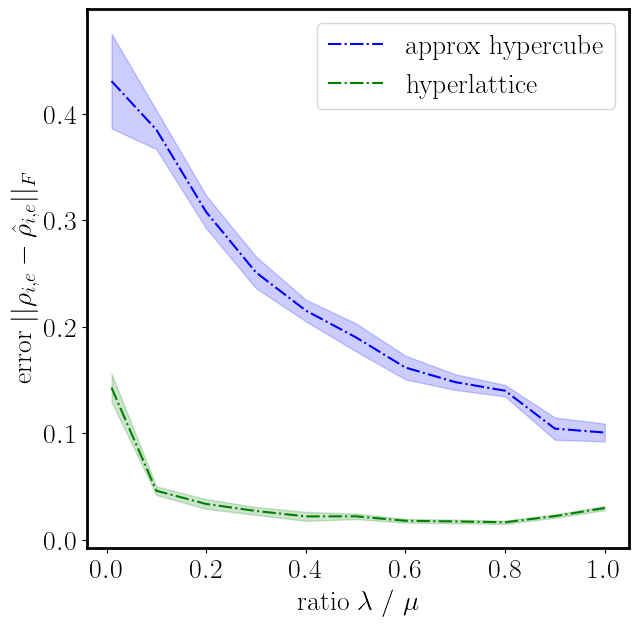

In [33]:
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rc('text', usetex=True)

font = {
    'family' : 'serif',
    'weight' : 'normal',
    'size'   : 20}
plt.rc('font', **font)
mpl.rcParams['axes.linewidth'] = 2

cub_Rho_frob_paths_T = np.transpose(np.array(cub_Rho_frob_paths))
avg_cub_Rho_frob_T = np.mean(cub_Rho_frob_paths_T, axis=1)

lat_Rho_frob_paths_T = np.transpose(np.array(lat_Rho_frob_paths))
avg_lat_Rho_frob_T = np.mean(lat_Rho_frob_paths_T, axis=1)


fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot()

ax.plot(lam_list, avg_cub_Rho_frob_T, ls='-.', color = 'blue', label = 'approx hypercube')
ax.plot(lam_list, avg_lat_Rho_frob_T, ls='-.', color = 'green', label = 'hyperlattice')

plt.xlabel(r'ratio $\lambda \ / \ \mu$')
plt.ylabel(r'error $||\rho_{i,e} - \hat{\rho}_{i,e}||_{F}$')
plt.legend()

cub_ci = 1.96 * np.std(cub_Rho_frob_paths_T, axis=1)/np.sqrt(10)
lat_ci = 1.96 * np.std(lat_Rho_frob_paths_T, axis=1)/np.sqrt(10)

plt.fill_between(lam_list, (avg_cub_Rho_frob_T - cub_ci), (avg_cub_Rho_frob_T + cub_ci), color='blue', alpha=.2)
plt.fill_between(lam_list, (avg_lat_Rho_frob_T - lat_ci), (avg_lat_Rho_frob_T + lat_ci), color='green', alpha=.2)

# plt.savefig('plot/big_rho_ci_approx.png', dpi=300)